In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import requests

from opencage.geocoder import OpenCageGeocode


In [ ]:
!pip install opencage

**Analyze the geographic distribution of transactions by city.**

In [ ]:
deals = pd.read_excel('new_Deals.xlsx')

In [ ]:
# посчитаем по городам общее количество сделок и успешных
city_deals = deals.groupby('City').apply(lambda x: pd.Series({
    'Total Deals': x['Id'].count(),
    'Successful Deals': (x['Stage'] == 'Payment Done').sum(),
})).reset_index()
city_deals

,City,Total Deals,Successful Deals
0,Aachen,9,3
1,Aalen,1,0
2,Abensberg,1,0
3,Achberg,1,1
4,Adelebsen,1,0
...,...,...,...
871,Zwingenberg,1,0
872,Öhringen,1,1
873,Übelbach,1,1
874,Überlingen,1,0


errors were found in the entries during work:
Could not find coordinates for the city: Alzenau in Unterfranken
Could not find coordinates for the city: Bad Wildbad im Schwarzwald
Could not find coordinates for the city: Poland , Gdansk , Al. Grunwaldzka 7, ap. 1a
so let's process the errors first

In [ ]:
# We replace incorrect city names with correct ones
city_deals['City'] = city_deals['City'].replace({
    'Alzenau in Unterfranken': 'Alzenau',
    'Bad Wildbad im Schwarzwald': 'Bad Wildbad',
    'Poland , Gdansk , Al. Grunwaldzka 7, ap. 1a': 'Gdansk'
})

In [ ]:
city_deals['City'].unique()

array(['Aachen', 'Aalen', 'Abensberg', 'Achberg', 'Adelebsen',
       'Adelschlag', 'Ahad Al Masarihah', 'Ahaus', 'Ahrensburg',
       'Aichach', 'Aichwald', 'Aidlingen', 'Ajman', 'Alamudun',
       'Albstadt', 'Aldenhoven', 'Alfeld', 'Allendorf', 'Almaty',
       'Alsbach-Hähnlein', 'Alsfeld', 'Altenburg', 'Altenkirchen',
       'Altenstadt', 'Altlandsberg', 'Altshausen', 'Altötting', 'Alzenau',
       'Amberg', 'Ampfing', 'Anklam', 'Annaberg-Buchholz', 'Ansbach',
       'Apen', 'Appen', 'Arnsberg', 'Arnstadt', 'Aschaffenburg',
       'Aschersleben', 'Astana', 'Augsburg', 'Aying', 'Babenhausen',
       'Backnang', 'Bad Abbach', 'Bad Berleburg', 'Bad Blankenburg',
       'Bad Driburg', 'Bad Ems', 'Bad Emstal', 'Bad Essen',
       'Bad Feilnbach', 'Bad Friedrichshall', 'Bad Gandersheim',
       'Bad Gottleuba-Berggießhübel', 'Bad Hersfeld', 'Bad Hindelang',
       'Bad Homburg vor der Höhe', 'Bad Hönningen', 'Bad Nauheim',
       'Bad Oeynhausen', 'Bad Pyrmont', 'Bad Saulgau', 'Bad Schw

# **Getting coordinates for each city**

To obtain coordinates, we use the OpenCage Geocoder geocoding service

In [ ]:
# key = '---'
# geocoder = OpenCageGeocode(key)

def geocode_city(city):
    try:
        result = geocoder.geocode(city)
        if result and len(result):
            return result[0]['geometry']['lat'], result[0]['geometry']['lng']
        else:
            print(f"Не удалось найти координаты для города: {city}")
            return (None, None)
    except Exception as e:
        print(f"Ошибка геокодирования для города {city}: {e}")
        return (None, None)

# Getting coordinates for each city
city_deals[['lat', 'lng']] = city_deals['City'].apply(lambda city: pd.Series(geocode_city(city)))


In [ ]:
# We remove lines with missing coordinate values
city_deals_clean = city_deals.dropna(subset=['lat', 'lng'])

In [ ]:
# Creating a 'geometry' column for a GeoDataFrame
geometry = [Point(xy) for xy in zip(city_deals_clean['lng'], city_deals_clean['lat'])]
gdf = gpd.GeoDataFrame(city_deals_clean, geometry=geometry)

In [ ]:
file_name = ('geo_deals.xlsx')
gdf.to_excel(file_name, index=False)

if necessary, we will use the saved file for the presentation**

In [ ]:
city_deals_clean = pd.read_excel('geo_deals.xlsx')

In [ ]:
# Create a map centered on average coordinates
start_coords = [city_deals_clean['lat'].mean(), city_deals_clean['lng'].mean()]
m = folium.Map(location=start_coords, zoom_start=6)

# Creating a MarkerCluster for Clustering City Markers
marker_cluster = MarkerCluster().add_to(m)

# Adding markers for each city
for index, row in city_deals_clean.iterrows():
    # Condition for changing the marker color depending on the number of successful trades
    if row['Successful Deals'] > 50:
        marker_color = 'green'
    elif row['Successful Deals'] > 40:
        marker_color = 'orange'
    elif row['Successful Deals'] > 30:
        marker_color = 'yellow'
    elif row['Successful Deals'] > 20:
        marker_color = 'blue'
    else:
        marker_color = 'pink'

# Adding a marker with a specific color
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=f"{row['City']}: {row['Total Deals']} total deals, {row['Successful Deals']} successful deals",
        icon=folium.Icon(color=marker_color)
    ).add_to(marker_cluster)

# Map display
m

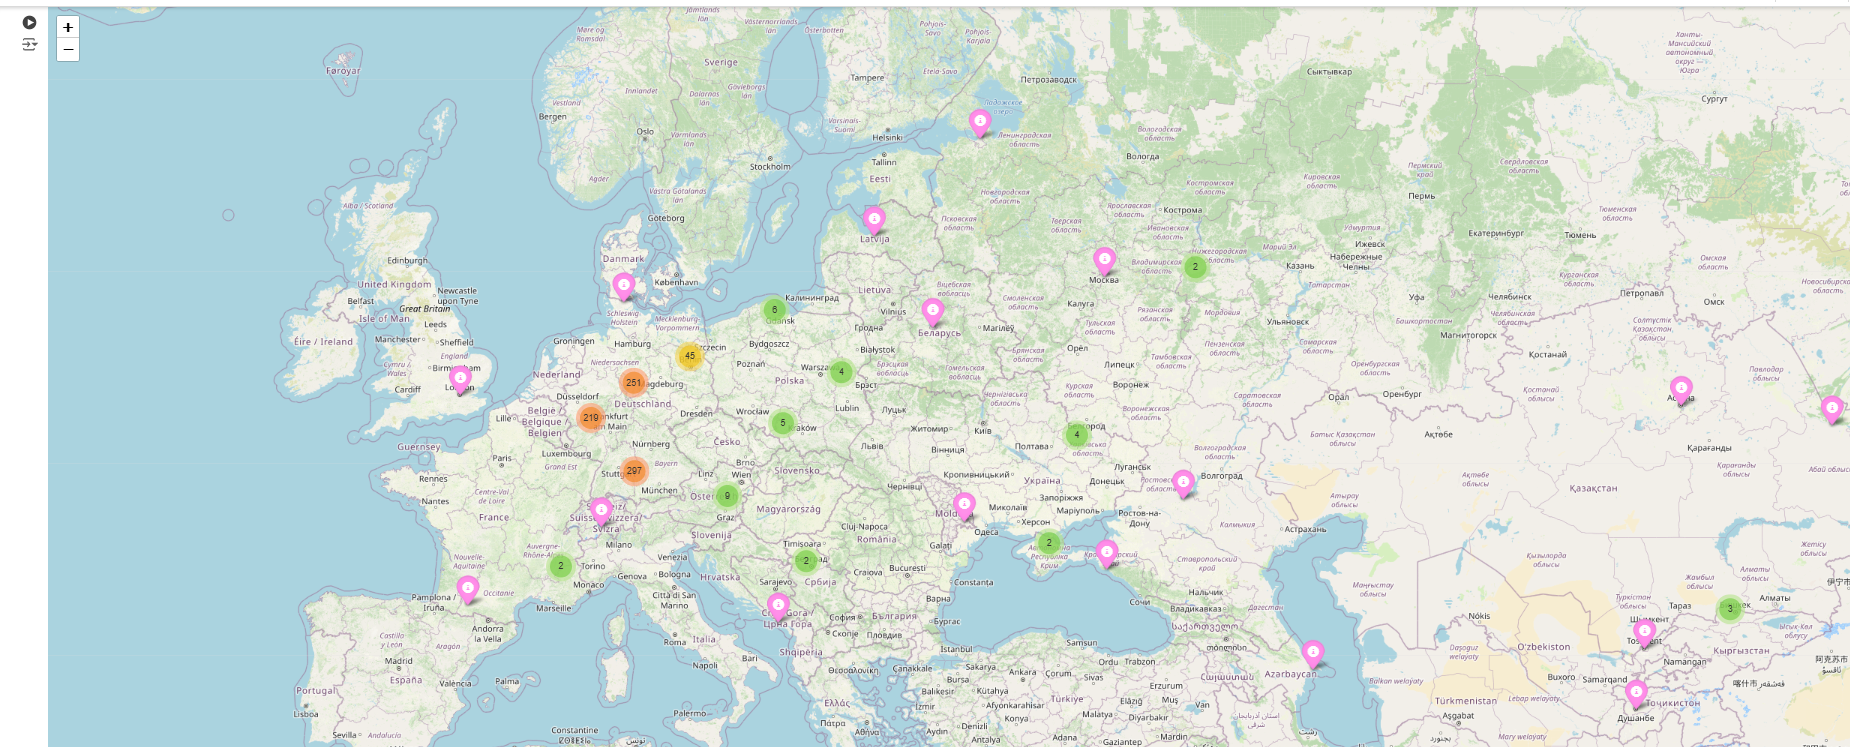

All city markers are added to a cluster, so markers that are close to each other are grouped into one cluster marker, showing the number of objects in this cluster. When you approach the map or click on a cluster marker, it expands, showing individual markers of cities located in this cluster. Depending on the value of Successful Deals, the city marker is colored in the selected color. The map shows the dispersion of clients


**Explore the impact of German language proficiency on the success of deals in different cities.**

First of all, let's clean up the data in the Level of Deutsch column

In [ ]:
def replace_letters(text):
    if isinstance(text, str):
        text = text.replace('А', 'A').replace('а', 'A')
        text = text.replace('Б', 'B').replace('б', 'B')
        text = text.replace('В', 'B').replace('в', 'B')
        text = text.replace('С', 'C').replace('с', 'C')
    return text

In [ ]:
# Replacing letters
deals['Level of Deutsch'] = deals['Level of Deutsch'].apply(replace_letters)

In [ ]:
deals['Level of Deutsch'].unique()

array(['Unknown', 'B1', 'A2', 'b1', 'B1-B2', 'B2', 'C2', 'C1', 'A1', 'A0',
       'B1 Bудет B феBрAле 2025', 'Detmold, Paulinenstraße 95, 32756',
       'CAм оцениBAет нA B2, 13 лет жиBет B ГермAнии', 'B1 ( ждет B2)',
       'A2-B1',
       'lэкзAмен - 6 июля нA B1. курCы Bечером (но уBеренно гоBорит нA B1)',
       'ГрAждAнкA ГермAнии уже год B ГермAнии Учит немецкий и B CентяBре b1 через гоC-Bо проходит, A не через ДЖЦ, Bечером учитCя 3 р B неделю C 18 до 21',
       '-', 'A2 ( B1 B июне)', 'B1 B процеCCе оBучения',
       'ЯЗ: нем B1 Bыл экз 03.05 поBтор и CейчAC ждет результAты. ТехничеCкий Aнгл Bыл. A1 CейчAC. ОBР: 2 Bо информAционные и комп Cети - инженер CиCтемоте',
       'B1 B CентяBре', 'Нет', 0, 'Ждем B1', 'A1 Cертиф, но по фAкту A2',
       'a2', 'ПокA A2, CдAет 17 05 B1', 'окончAние 13.06 курCA нA b1',
       'b2', 'Thorn-Prikker-Str. 30, Hagen, 58093',
       'нулеBой уроBень, только пошел нA курCы.', 'Aя B1',
       'Ждет результAт по B1', 'A2( ждет итоги B!)',
       'b

In [ ]:
import re

def extract_level(text):
    if isinstance(text, str):
        text = text.upper()

        match = re.search(r'\b[A-C][12]\b', text)

        if match:
            return match.group(0)

        if '-' in text:
            parts = text.split('-')
            match = re.search(r'\b[A-C][12]\b', parts[1])
            if match:
                return match.group(0)

        match = re.search(r'[A-C][12]', text)
        if match:
            return match.group(0)

    return text

In [ ]:
deals['Level of Deutsch'] = deals['Level of Deutsch'].apply(extract_level)

In [ ]:
unknown_values = ['DETMOLD, PAULINENSTRASSE 95, 32756',
                  '-',
                  'THORN-PRIKKER-STR. 30, HAGEN, 58093',
                  'PADERBORN 33102, SCHWABENWEG 10',
                  '31.05.2024',
                  'LICHTENFELSER STRASSE 25, UNTERSIEMAU 96253',
                  'НЕ УЧИЛ',
                  '?',
                  'F2',
                  90,
                  '.',
                  'УТОЧНИТЬ!',
                  'УТОЧНИТЬ',
                  'РAЗГОBОРНЫЙ ИЗ УКРAИНЫ, BЕЗ CЕРТИФИКAТA',
                  'ТОЧНО УРОBЕНЬ НЕ ЗНAЮ, НО ГОBОРИТЬ МОГУ - УЧИЛA CAМA',
                  'НИКAКОЙ']

deals['Level of Deutsch'] = deals['Level of Deutsch'].replace(unknown_values, 'UNKNOWN')

In [ ]:
unknown_values_a = ['НЕТ',
                  0,
                  'НУЛЕBОЙ УРОBЕНЬ, ТОЛЬКО ПОШЕЛ НA КУРCЫ.',
                  'A']

deals['Level of Deutsch'] = deals['Level of Deutsch'].replace(unknown_values_a, 'A0')

In [ ]:
unknown_values_a1 = ['A']

deals['Level of Deutsch'] = deals['Level of Deutsch'].replace(unknown_values_a1, 'A0')

In [ ]:
unknown_values_b = ['B',
                    'НЕ УЧИЛA ( РAЗГОBОРНЫЙ) CРAЗУ ПОШЛA РABОТAТЬ',
                    'BЙ']

deals['Level of Deutsch'] = deals['Level of Deutsch'].replace(unknown_values_b, 'B1')

In [ ]:
unknown_values_c = ['ГРAЖДAНКA',
                    'ГРAЖДAНИН',
                    '25 ЛЕТ ЖИBЕТ B ГЕРМAНИИ',
                    'НЕ CДABAЛ, НО ГРAЖДAНИН',
                    'C']

deals['Level of Deutsch'] = deals['Level of Deutsch'].replace(unknown_values_c, 'C1')

In [ ]:
deals['Level of Deutsch'].unique()

array(['UNKNOWN', 'B1', 'A2', 'B2', 'C2', 'C1', 'A1', 'A0'], dtype=object)

In [ ]:
# filter data by cities and languages ​​- except "UNKNOWN"

# deals.loc[deals['City'] == '-', 'City'] = 'Unknown'
deals_clean = deals[deals['City'] != 'Unknown']
deals_clean = deals_clean[deals_clean['Level of Deutsch'] != 'UNKNOWN']

In [ ]:
(deals_clean['City'] == 'Unknown').sum()

0

In [ ]:
# We calculate the total number of transactions for each city
city_total_deals = deals_clean.groupby('City')['Id'].count().reset_index().rename(columns={'Id': 'City Total Deals'})
city_total_deals

,City,City Total Deals
0,Aachen,6
1,Adelschlag,1
2,Ahaus,1
3,Aichwald,1
4,Albstadt,2
...,...,...
471,Zeitz,1
472,Zella-Mehlis,1
473,Zorneding,1
474,Zwickau,1


In [ ]:
grouped_deals = deals_clean.groupby(['City', 'Level of Deutsch']).apply(lambda x: pd.Series({
    'Total Deals': x['Id'].count(),
    'Stage Done': (x['Stage'] == 'Payment Done').sum()
})).reset_index()
grouped_deals

,City,Level of Deutsch,Total Deals,Stage Done
0,Aachen,A2,1,0
1,Aachen,B1,5,2
2,Adelschlag,B1,1,0
3,Ahaus,B2,1,1
4,Aichwald,B1,1,1
...,...,...,...,...
591,Zeitz,B1,1,0
592,Zella-Mehlis,B1,1,0
593,Zorneding,B1,1,1
594,Zwickau,A2,1,1


In [ ]:
# Add the total number of transactions for each city
grouped_deals = grouped_deals.merge(city_total_deals, on='City', how='left')
grouped_deals

,City,Level of Deutsch,Total Deals,Stage Done,City Total Deals
0,Aachen,A2,1,0,6
1,Aachen,B1,5,2,6
2,Adelschlag,B1,1,0,1
3,Ahaus,B2,1,1,1
4,Aichwald,B1,1,1,1
...,...,...,...,...,...
591,Zeitz,B1,1,0,1
592,Zella-Mehlis,B1,1,0,1
593,Zorneding,B1,1,1,1
594,Zwickau,A2,1,1,1


In [ ]:
# Conversion of transactions by language levels relative to the total number in the city
grouped_deals['Conversion Total %'] = (grouped_deals['Total Deals'] / grouped_deals['City Total Deals']) * 100
grouped_deals['Conversion Done %'] = (grouped_deals['Stage Done'] / grouped_deals['City Total Deals']) * 100
grouped_deals

,City,Level of Deutsch,Total Deals,Stage Done,City Total Deals,Conversion Total %,Conversion Done %
0,Aachen,A2,1,0,6,16.666667,0.000000
1,Aachen,B1,5,2,6,83.333333,33.333333
2,Adelschlag,B1,1,0,1,100.000000,0.000000
3,Ahaus,B2,1,1,1,100.000000,100.000000
4,Aichwald,B1,1,1,1,100.000000,100.000000
...,...,...,...,...,...,...,...
591,Zeitz,B1,1,0,1,100.000000,0.000000
592,Zella-Mehlis,B1,1,0,1,100.000000,0.000000
593,Zorneding,B1,1,1,1,100.000000,100.000000
594,Zwickau,A2,1,1,1,100.000000,100.000000


We will conduct the analysis by cities on the cities with the largest number of transactions - more than 10 transactions

In [ ]:
key_cities = grouped_deals[grouped_deals['City Total Deals'] > 10]

key_cities

,City,Level of Deutsch,Total Deals,Stage Done,City Total Deals,Conversion Total %,Conversion Done %
49,Berlin,A0,2,1,83,2.409639,1.204819
50,Berlin,A1,2,1,83,2.409639,1.204819
51,Berlin,A2,13,3,83,15.662651,3.614458
52,Berlin,B1,48,30,83,57.831325,36.144578
53,Berlin,B2,14,5,83,16.867470,6.024096
54,Berlin,C1,4,2,83,4.819277,2.409639
106,Dortmund,A2,2,1,12,16.666667,8.333333
107,Dortmund,B1,6,1,12,50.000000,8.333333
108,Dortmund,B2,2,0,12,16.666667,0.000000
109,Dortmund,C1,2,0,12,16.666667,0.000000


In [ ]:
fig = px.bar(
    key_cities,
    x='City',
    y='Total Deals',
    color='Level of Deutsch',
    hover_data=['Conversion Total %', 'Conversion Done %'],
    title='Distribution of TOTAL number of transactions by City and Level of Deutsch',
)

fig.show()

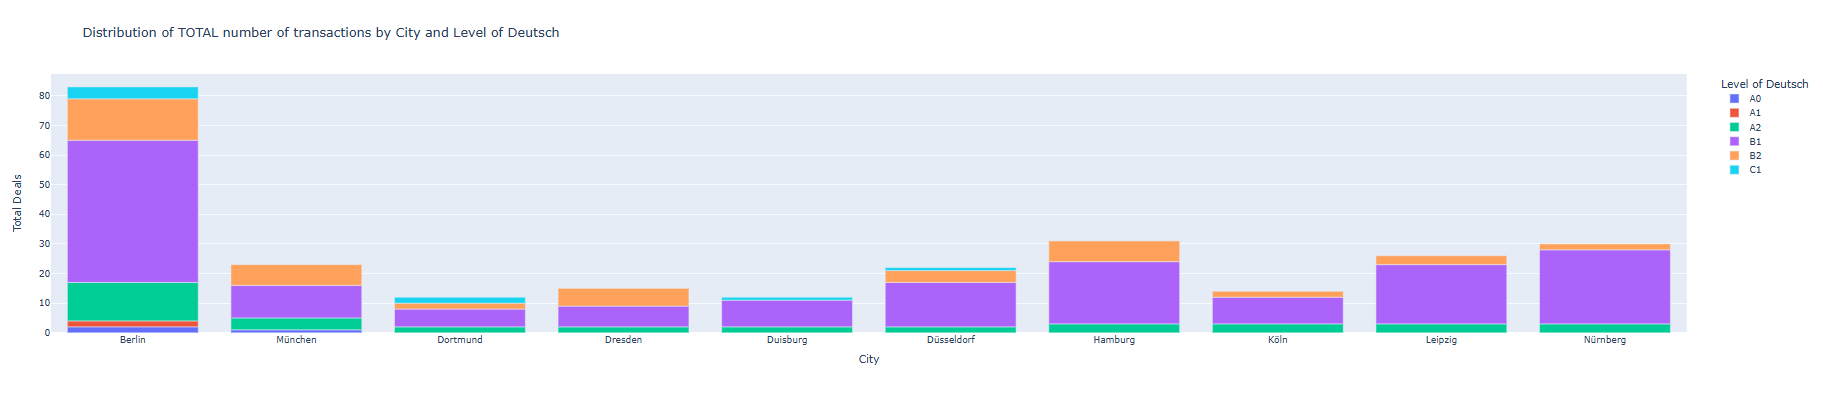

In [ ]:
fig = px.bar(
    key_cities,
    x='City',
    y='Stage Done',
    color='Level of Deutsch',
    hover_data=['City Total Deals', 'Total Deals'],
    title='Distribution of SUCCESSFUL transactions by City and Level of Deutsch'
)

fig.show()

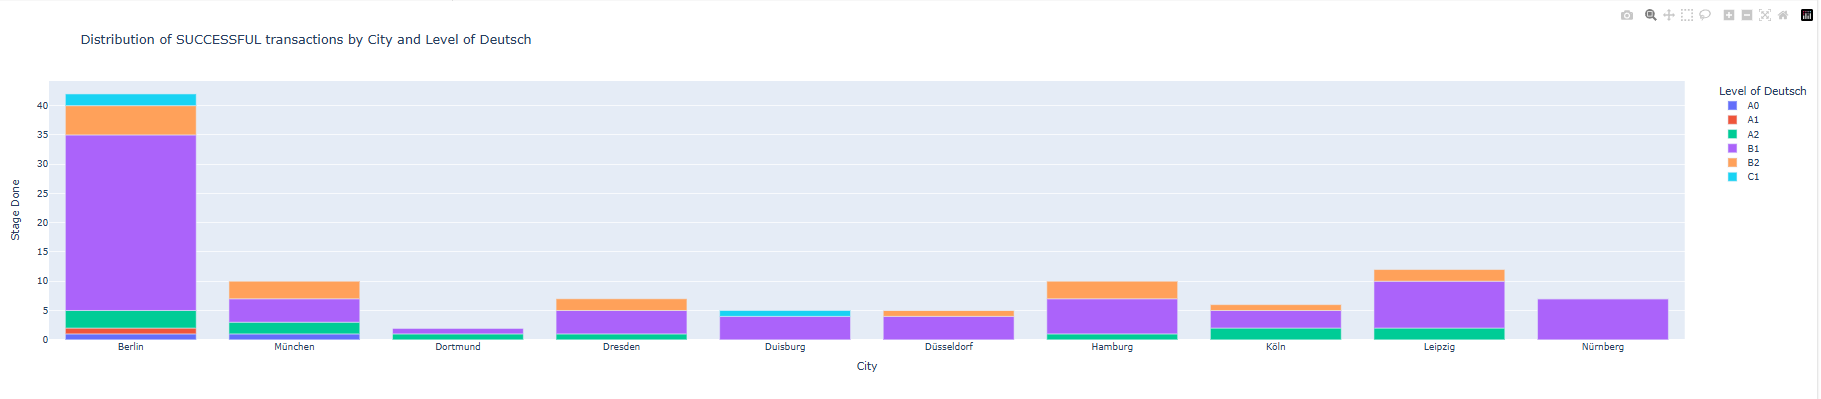

**Total number of transactions**
**Berlin** is the clear leader in terms of the number of transactions among all cities. The total number of transactions here is significantly higher than other cities. The main contributors to this result are people with level B1, then B2 and A2.
Other large cities such as **Munich, Hamburg, Nuremberg, Leipzig** show moderate results with a clear predominance of transactions at level B1 and B2.
The cities of **Dortmund, Dusseldorf, Cologne, Duisburg** show a small volume of transactions. However, contributors with levels B1 and B2 are also visible here.

The presence of transactions at level C1 and A0 is rare, indicating low activity for people with these language proficiency levels.

**Successful transactions**
Berlin also leads in terms of the number of successful transactions, with the most noticeable contribution from people with levels B1 and B2, indicating a high success rate of transactions among these categories.
Levels A0, A1 and C1 also contributed, although to a lesser extent than the higher levels.
In the cities of **Munich, Hamburg, Leipzig and Nuremberg** successful deals are noticeable, with the dominance of level B1. In these cities, levels B2 and A2 also show some success.
In **Dortmund and Duisburg** levels B1 and A2 also contribute to successful deals, but to a lesser extent.
Levels C1 have a very small contribution to successful deals, especially in cities with a lower overall number of deals, such as** Düsseldorf and Cologne.**

In both graphs, it is clear that the most successful deals are those associated with level B1**, which may indicate that these people are sufficiently qualified to conduct deals.
Berlin dominates both in the total number and in successful deals, indicating its economic activity and the diversity of participants with different levels of German proficiency. The graphs show a trend that people with levels B1 and B2 are the most active and successfully complete deals, while levels A0 and C1 are less active.
In some cities, such as **Leipzig, Munich, and Nuremberg**, deal success is also high for people with level B1, which confirms the general trend in the country.
Thus, we see that proficiency in German at levels B1 and B2 **is a key factor for successful deal making, especially in large cities such as Berlin, Munich, and Hamburg.